In [1]:
import os
import random
import json

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import torch
from PIL import Image
from sklearn.decomposition import PCA

import MENDER
from miso import Miso
from miso.hist_features import get_features
from miso.utils import *

/opt/anaconda3/envs/momender/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/anaconda3/envs/momender/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
Image.MAX_IMAGE_PIXELS = None
Image.MAX_IMAGE_PIXELS = None

seed = 100
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    device = "cuda"
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("CUDA is available. GPU:", torch.cuda.get_device_name(0))
else:
    device = "cpu"
    print("CUDA is not available. Using CPU.")


CUDA is not available. Using CPU.


# Contants, Placeholder, and Data

Data used in this notebook is available on https://explore.data.humancellatlas.org/projects/957261f7-2bd6-4358-a6ed-24ee080d5cfc.

I only use the 3 samples with tiff images included (namely, WSA_LngSP10193347, WSA_LngSP10193346, and WSA_LngSP10193347).

In [3]:
data_dir = "data"
lung_datadir = os.path.join(data_dir, "human_lung")

result_dir = "results"
fig_result_dir = os.path.join(result_dir, "figures")

In [4]:
sample_names = [
    "WSA_LngSP10193345",
    "WSA_LngSP10193346",
    "WSA_LngSP10193347",
]

In [5]:
# Empty placeholders
adataset = {}
tiff_images = {}
coord_list = {}
image_emb_list = {}
miso_emb_list = {}
miso_emb_list = {}
result_list = {}
score_list = {}

In [6]:
for sample_name in sample_names:
    sample_dir = os.path.join(lung_datadir, sample_name)
    adataset[sample_name] = sq.read.visium(sample_dir)
    adataset[sample_name].var_names_make_unique()
    tiff_images[sample_name] = Image.open(os.path.join(sample_dir, f"{sample_name}.tif"))
    coord_list[sample_name] = pd.read_csv(
        os.path.join(sample_dir, "spatial", "tissue_positions_list.csv"),
        index_col=0,
        header=None,
    )

/opt/anaconda3/envs/momender/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/momender/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/momender/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/momender/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/momender/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable n

In [7]:
# Constants for MISO image embeddings

#microns per pixel in H&E image
pixel_size_raw = 65/255.54640512302527
#desired microns per pixel
pixel_size = 0.5
#spot radius in pixels
rad=55/(2*pixel_size_raw)

In [8]:
# Constants for MENDER
cell_type_key = "ct"


n_scales = 3
nn_para = 6
nn_mode='ring'

# MISO: Image Embeddings and Multi-modal Embeddings

In [9]:
for sample_name in sample_names:
    print(f" Working on sample: {sample_name}".center(80, "*"))
    sample_dir = os.path.join(lung_datadir, sample_name)
    emb_path = os.path.join(sample_dir, "image_emb.npy")
    if os.path.exists(emb_path):
        print(f"Loading from {emb_path} ...")
        image_emb = np.load(emb_path)
    else:
        coord_list[sample_name].columns = [str(i) for i in range(1, 6)]
        image_emb = get_features(
            tiff_images[sample_name],
            coord_list[sample_name],
            rad,
            pixel_size_raw,
            pixel_size,
            pretrained=True,
            device=device,
        )
        np.save(emb_path, image_emb)
    image_emb_list[sample_name] = image_emb

********************* Working on sample: WSA_LngSP10193345**********************
Loading from data/human_lung/WSA_LngSP10193345/image_emb.npy ...
********************* Working on sample: WSA_LngSP10193346**********************
Loading from data/human_lung/WSA_LngSP10193346/image_emb.npy ...
********************* Working on sample: WSA_LngSP10193347**********************
Loading from data/human_lung/WSA_LngSP10193347/image_emb.npy ...


In [10]:
def filter_image_emb(image_emb, filtered_idx, original_idx):
    keep_dims = [(i in filtered_idx) for i in original_idx]
    return image_emb[keep_dims] 

In [ ]:
for sample_name in sample_names:
    print(f" Working on sample: {sample_name}".center(80, "*"))
    sample_dir = os.path.join(lung_datadir, sample_name)
    emb_path = os.path.join(sample_dir, "miso_emb.npy")

    if os.path.exists(emb_path):
        print(f"Loading from {emb_path} ...")
        miso_emb = np.load(emb_path)
    else:
    # if True:
        print("Extracting Miso embeddings ...")
        original_idx = list(coord_list[sample_name].index)
        
        rna = adataset[sample_name].copy()
        rna = preprocess(rna, modality="rna")
        filtered_idx = list(rna.obs_names)
        rna_mat = rna.X.toarray()
        
        # print(len(original_idx), len(filtered_idx))
        
        image_emb = image_emb_list[sample_name]
        filtered_image_emb = filter_image_emb(image_emb, filtered_idx, original_idx)

        # print(rna_mat.shape, filtered_image_emb.shape)

        model = Miso(
            [rna_mat, filtered_image_emb],
            ind_views="all",
            combs="all",
            sparse=False,
            device=device,
        )
        model.train()
        miso_emb = model.emb

        np.save(emb_path, miso_emb)

    miso_emb_list[sample_name] = miso_emb


********************* Working on sample: WSA_LngSP10193345**********************
Extracting Miso embeddings ...


Training network for modality 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training network for modality 2:   0%|          | 0/1000 [00:00<?, ?it/s]

********************* Working on sample: WSA_LngSP10193346**********************
Extracting Miso embeddings ...


Training network for modality 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training network for modality 2:   0%|          | 0/1000 [00:00<?, ?it/s]

********************* Working on sample: WSA_LngSP10193347**********************
Extracting Miso embeddings ...


Training network for modality 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training network for modality 2:   0%|          | 0/1000 [00:00<?, ?it/s]

# MENDER: Spatial Domain Identification

In [12]:
def run_mender(adata, processed: bool = True):
    if not processed:
        print("Processing RNA data ...")
        sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
        sc.pp.normalize_total(adata, inplace=True)
        sc.pp.log1p(adata)
        sc.pp.pca(adata)
    # else:
    #     sc.pp.neighbors(adata, use_rep="X")
    

    print("Cell typing ...")
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata, resolution=2, key_added=cell_type_key)
    adata.obs[cell_type_key] = adata.obs[cell_type_key].astype("category")

    msm = MENDER.MENDER_single(adata, ct_obs=cell_type_key)

    msm.set_MENDER_para(
        n_scales=n_scales,
        nn_mode=nn_mode,
        nn_para=nn_para,
    )

    print("Running main body ...")
    msm.run_representation()
    msm.run_clustering_normal(-0.2)

    # chaos = MENDER.compute_CHAOS(msm.adata_MENDER, pred_key="MENDER")
    # pas = MENDER.compute_PAS(msm.adata_MENDER, pred_key="MENDER")
    return msm.adata_MENDER

In [13]:
def plot_clusters(adata, sample_name, method, obs="MENDER", obs_gt="gt", save_fig=True):
    # adata.obs[self.batch_obs] = adata.obs[self.batch_obs].astype("category")
    # for si in adata.obs[self.batch_obs].cat.categories:
    #     adata = adata[adata.obs[self.batch_obs] == si]

    if obs_gt in adata.obs:
        nmi = MENDER.compute_NMI(adata, obs_gt, obs)
        ari = MENDER.compute_ARI(adata, obs_gt, obs)
        # nmi = np.round(nmi, 3)
        # ari = np.round(ari, 3)

    pas = MENDER.compute_PAS(adata, obs)
    chaos = MENDER.compute_CHAOS(adata, obs)
    # pas = np.round(pas,3)
    # chaos = np.round(chaos,3)

    if obs_gt in adata.obs:
        title = f'{sample_name}\n {method}\n nmi:{nmi}\n ari: {ari}\n pas:{pas}\n chaos:{chaos}'
        # title = f"{si}\n nmi:{nmi} ari: {ari}"
    else:
        title = f"{sample_name}\n {method}\n pas:{pas}\n chaos:{chaos}"
        # title = si

    fig = plt.figure()
    ax = sc.pl.embedding(adata, basis="spatial", color=obs, show=False)
    # fig.add_axes(ax)
    ax.axis("equal")
    ax.set_title(title)
    if save_fig:
        plt.savefig(
            os.path.join(fig_result_dir, f"human_lung_{sample_name}_{method}"), 
            dpi=500,
            bbox_inches='tight', 
            pad_inches=0,
        )

Working on sample WSA_LngSP10193345 ...
Processing RNA data ...
Cell typing ...


/var/folders/8c/jcychwqs1xj1fdt9qbthnzdh0000gn/T/ipykernel_52513/489116901.py:14: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=2, key_added=cell_type_key)


Running main body ...
scale 0, median #cells per ring (r=6): 7.0
scale 1, median #cells per ring (r=6): 12.0
scale 2, median #cells per ring (r=6): 18.0
Cell typing ...
Running main body ...
scale 0, median #cells per ring (r=6): 7.0
scale 1, median #cells per ring (r=6): 12.0
scale 2, median #cells per ring (r=6): 18.0
Working on sample WSA_LngSP10193346 ...
Processing RNA data ...
Cell typing ...
Running main body ...
scale 0, median #cells per ring (r=6): 7.0
scale 1, median #cells per ring (r=6): 12.0
scale 2, median #cells per ring (r=6): 18.0
Cell typing ...
Running main body ...
scale 0, median #cells per ring (r=6): 7.0
scale 1, median #cells per ring (r=6): 12.0
scale 2, median #cells per ring (r=6): 18.0
Working on sample WSA_LngSP10193347 ...
Processing RNA data ...
Cell typing ...
Running main body ...
scale 0, median #cells per ring (r=6): 7.0
scale 1, median #cells per ring (r=6): 12.0
scale 2, median #cells per ring (r=6): 18.0
Cell typing ...
Running main body ...
scale

<Figure size 640x480 with 0 Axes>

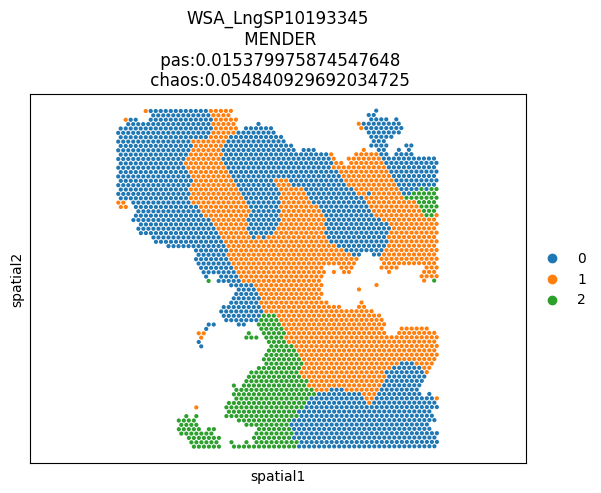

<Figure size 640x480 with 0 Axes>

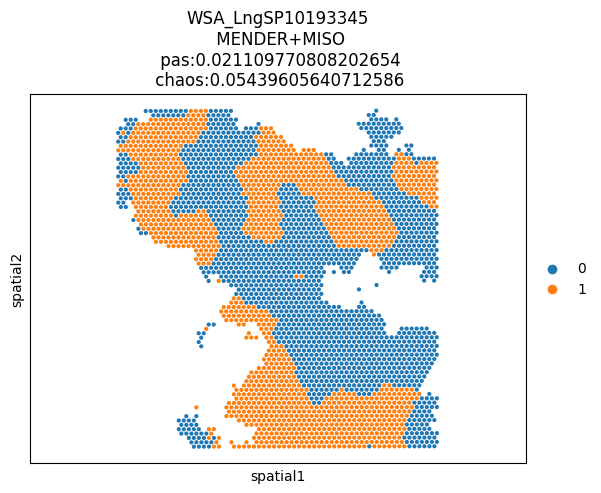

<Figure size 640x480 with 0 Axes>

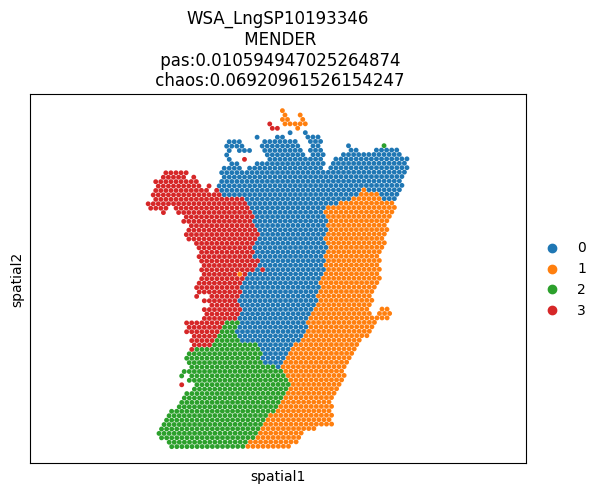

<Figure size 640x480 with 0 Axes>

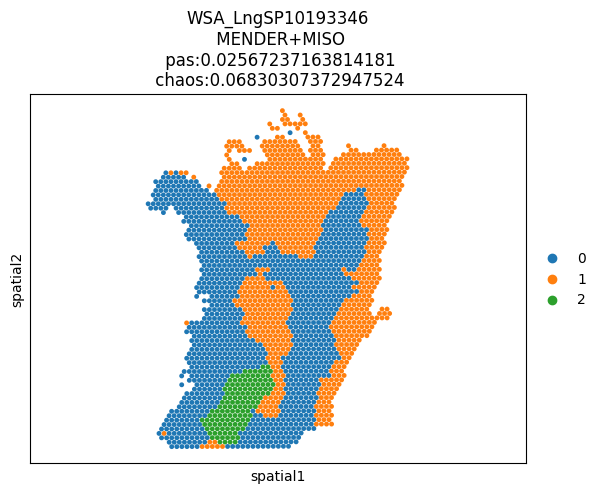

<Figure size 640x480 with 0 Axes>

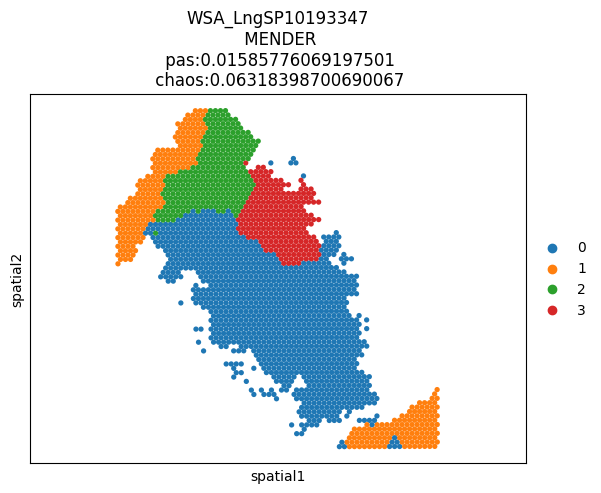

<Figure size 640x480 with 0 Axes>

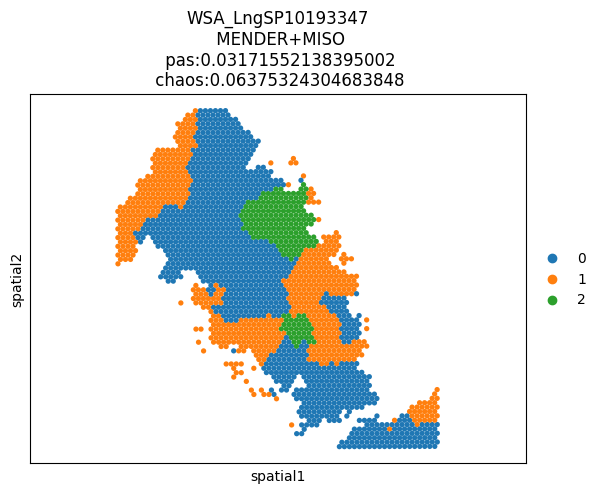

In [14]:
for sample_name in sample_names:
    sample_dir = os.path.join(lung_datadir, sample_name)
    print(f"Working on sample {sample_name} ...")

    adata = adataset[sample_name].copy()
    res_adata = run_mender(adata, processed=False)
    pas = MENDER.compute_PAS(res_adata, "MENDER")
    chaos = MENDER.compute_CHAOS(res_adata, "MENDER")
    plot_clusters(res_adata, sample_name, method="MENDER")

    miso_emb = np.nan_to_num(miso_emb_list[sample_name])
    adata_miso = ad.AnnData(
        X=miso_emb,
        obs=adataset[sample_name].obs.copy(),
        obsm=adataset[sample_name].obsm.copy(),
        uns=adataset[sample_name].uns.copy(),
    )
    adata_miso.obsm["X_pca"] = miso_emb
    res_miso = run_mender(adata_miso, processed=True)
    pas_miso = MENDER.compute_PAS(res_miso, "MENDER")
    chaos_miso = MENDER.compute_CHAOS(res_miso, "MENDER")
    plot_clusters(res_miso, sample_name, method="MENDER+MISO")

    result_list[sample_name] = {
        "MENDER": res_adata.copy(),
        "MENDER+MISO": res_miso.copy()
    }

    score_list[sample_name] = {
        "MENDER": {"pas": float(pas), "chaos": float(chaos)},
        "MENDER+MISO": {"pas": float(pas_miso), "chaos": float(chaos_miso)}
    }
    # print(f"MENDER: chaos: {chaos}, pas: {pas}" )
    # print(f"MENDER+MISO: chaos: {chaos_mis}, pas: {pas_mis}")


In [15]:
with open(os.path.join(result_dir, "human_lung.json"), "w") as f:
    json.dump(score_list, f, indent=4)
score_list

{'WSA_LngSP10193345': {'MENDER': {'pas': 0.015379975874547648,
   'chaos': 0.054840929692034725},
  'MENDER+MISO': {'pas': 0.021109770808202654, 'chaos': 0.05439605640712586}},
 'WSA_LngSP10193346': {'MENDER': {'pas': 0.010594947025264874,
   'chaos': 0.06920961526154247},
  'MENDER+MISO': {'pas': 0.02567237163814181, 'chaos': 0.06830307372947524}},
 'WSA_LngSP10193347': {'MENDER': {'pas': 0.01585776069197501,
   'chaos': 0.06318398700690067},
  'MENDER+MISO': {'pas': 0.03171552138395002, 'chaos': 0.06375324304683848}}}

In [16]:
adataset["WSA_LngSP10193345"]

AnnData object with n_obs × n_vars = 3316 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'